In [1]:
import eikon as ek
import pandas as pd
import matplotlib.pyplot as plt
import requests

%matplotlib inline

In [2]:
ek.set_app_key('b499c15480534749a47879878c132348412d0c30')

getting the sp500 stock names from wikipedia 

In [3]:
data, _ = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')

In [4]:
symbols = data['Symbol'].tolist()
symbols[:10]

['MMM', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'ADBE', 'AMD', 'AAP', 'AES']

the symbols come in the <span style="color:red">'ticker'</span> form, need to convert them to <span style="color:red">'RIC'</span> or otherwise wont be able to retrieve any data

In [5]:
def ticker_to_rics(symbols: list) -> list: 
    rics = ek.symbology.get_symbology(symbols, 
                                      from_symbol_type='ticker',
                                      to_symbol_type='RIC',
                                      bestMatch=False)
    rics = rics['RICs'].apply(func).values
    return rics.tolist()

def func(x):
    if [i for i in x[0] if i.islower()]:
        return x[1]
    return x[0]

retrieving the data for all stocks of SP500 takes about 30 seconds 

In [23]:
df, _ =  ek.get_data(instruments=ticker_to_rics(symbols), 
                     fields=['TR.ClosePrice', 'TR.PE', 'TR.EPSMean'])

In [24]:
df.head(10)

,Instrument,Close Price,P/E (Daily Time Series Ratio),Earnings Per Share - Mean
0,MMM,151.21,17.141795,8.20578
1,ABT,99.93,57.805441,3.24430
2,ABBV.K,94.29,17.147502,10.45571
3,ABMD.O,305.35,68.955783,3.34611
4,ACN,227.15,29.589537,7.63846
5,ATVI.O,86.45,42.769505,2.96207
6,ADBE.O,446.92,58.882353,9.76675
7,AMD.O,85.04,169.001769,1.09518
8,AAP,152.79,27.845564,6.57076
9,AES,15.47,35.363233,1.38000


some of the values for P/E will be NaN for the symbols with negative earnings, thats fine

In [25]:
df[df.isna().any(axis=1) == True].head(10)

,Instrument,Close Price,P/E (Daily Time Series Ratio),Earnings Per Share - Mean
24,MO,41.600,NaN,4.32169
28,AAL.O,11.470,NaN,-19.13967
39,.ADI,4305.917,NaN,NaN
44,APA.O,15.880,NaN,-1.86426
60,BKR,16.190,NaN,-0.45720
71,BA,165.070,NaN,-9.29400
84,COF,63.240,NaN,-2.27079
85,CAH,57.830,NaN,5.30935
87,CCL,13.740,NaN,-7.10360
95,CNP,19.490,NaN,1.29479


TODO address symbols with nan earnings below

In [26]:
df[df['Earnings Per Share - Mean'].isnull()]

,Instrument,Close Price,P/E (Daily Time Series Ratio),Earnings Per Share - Mean
39,.ADI,4305.917,NaN,NaN
178,ESc1,3299.250,NaN,NaN
204,FOX.L,2.150,NaN,NaN
296,L,35.380,NaN,NaN


In [27]:
df = df[df['Earnings Per Share - Mean'] > 0 ]

____
Using 

(tp - p) / tp

In [28]:
df['diff'] = (df['Earnings Per Share - Mean']*15 - df['Close Price']
) / df['Earnings Per Share - Mean']*15

In [29]:
df.sort_values(ascending=False, by='diff')

,Instrument,Close Price,P/E (Daily Time Series Ratio),Earnings Per Share - Mean,diff
464,UNM,16.93,3.606248,5.18927,176.062481
330,MYL.O,16.32,135.424446,4.36625,168.933581
291,LNC,36.51,10.965051,8.27683,158.833364
220,HRB,13.90,145.824591,2.57644,144.074382
258,IVZ,9.77,9.622298,1.55306,130.637902
...,...,...,...,...,...
453,UDR,35.18,56.283497,0.13256,-3755.838865
211,GE,6.14,16.112102,0.00848,-10635.849057
409,SBAC.O,310.31,NaN,0.23994,-19174.224806
45,AIV,36.55,29.982855,0.01783,-30523.738082


####


In [15]:
df['Price at P/E = 15'] = 15*df['Earnings Per Share - Mean']
df['Diff'] = (df['Close Price'] - df['Price at P/E = 15']) / df['Close Price']

#### The 'undervalued' stocks:

In [11]:
df.sort_values(by='Diff', ascending=True).head(10)

,Instrument,Close Price,P/E (Daily Time Series Ratio),Earnings Per Share - Mean,Price at P/E = 15,Diff
464,UNM,17.23,3.670151,5.18564,77.78460,-3.514486
330,MYL.O,16.11,133.681852,4.36813,65.52195,-3.067160
291,LNC,37.27,11.193301,8.27683,124.15245,-2.331163
220,HRB,14.50,152.119178,2.54089,38.11335,-1.628507
160,DXC,17.91,NaN,2.89914,43.48710,-1.428090
258,IVZ,10.04,9.888216,1.55272,23.29080,-1.319801
148,DISCK.O,18.95,7.269871,2.83500,42.52500,-1.244063
473,VIAC.O,26.07,6.055637,3.87200,58.08000,-1.227848
314,MET,37.85,4.030721,5.47958,82.19370,-1.171564
383,PRU,63.37,8.792377,9.13469,137.02035,-1.162227


___

In [24]:
def plot_lynch_chart(symbol:str, start: str, end: str,
                     pe1: int, pe2: int) -> pd.DataFrame:
    """
    args:
        symbol - in a rics, isin or cusip format
        start - in a format YYYY-MM-DD (strf %y-)
        pe1, pe2 - P/E ratio values to plot
    
    returns:
        plots lynch chart of a given security, 
        returns pandas df with the plotted data 
    
    requires TR Eikon connection, pandas and matplotlib.pyplot    
    """
    df, _ = ek.get_data(instruments=symbol,
                        fields=['TR.PriceClose.CalcDate',
                                'TR.PE',
                                'TR.PriceClose',
                                'TR.EPSMean'],
                        parameters={'SDate': start,
                                    'EDate': end})

    df[f'Price|P/E={pe1}'] = df['Earnings Per Share - Mean']*pe1
    df[f'Price|P/E={pe2}'] = df['Earnings Per Share - Mean']*pe2

    fig, ax = plt.subplots()
    ax.plot(df['Calc Date'],
            df['Price Close']) 

    ax.plot(df['Calc Date'],
            df[f'Price|P/E={pe1}'],
            label=f'P/E = {pe1}')

    ax.plot(df['Calc Date'],
            df[f'Price|P/E={pe2}'])
    
    plt.show()
    return df 

In [33]:
args = dict(symbol = 'WFC',
            start = '2018-08-01',
            end = '0',  # 0 for up until now
            pe1 = 10,
            pe2 = 15)

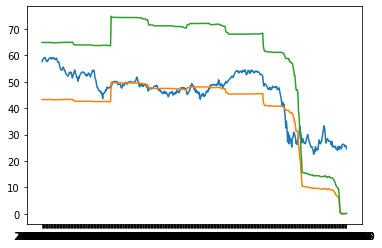

,Instrument,Calc Date,P/E (Daily Time Series Ratio),Price Close,Earnings Per Share - Mean,Price|P/E=10,Price|P/E=15
0,WFC,2018-08-01,16.294471,57.65,4.32471,43.2471,64.87065
1,WFC,2018-08-02,16.475363,58.29,4.32471,43.2471,64.87065
2,WFC,2018-08-03,17.130777,58.83,4.32471,43.2471,64.87065
3,WFC,2018-08-06,17.148248,58.89,4.32471,43.2471,64.87065
4,WFC,2018-08-07,17.127865,58.82,4.32471,43.2471,64.87065
...,...,...,...,...,...,...,...
498,WFC,2020-07-24,30.008342,26.26,0.00173,0.0173,0.02595
499,WFC,2020-07-27,29.128433,25.49,0.00173,0.0173,0.02595
500,WFC,2020-07-28,29.174142,25.53,0.00173,0.0173,0.02595
501,WFC,2020-07-29,29.459827,25.78,0.00536,0.0536,0.08040


In [34]:
plot_lynch_chart(*args.values())